# Lecture 04

Continue with the covid data set for:

* Bootstrap Sampling
* Hypothesis Testing


In [1]:
import numpy as np
import numpy.random as npr
import random
import itertools

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Visualizing Multiple Data Sets

In [2]:
import pandas as pd

df = pd.read_csv( './covid-merged.csv' ) # INPUT THE FILE
df.set_index('state', inplace=True) # USING STATE TO INDEX THE DATA

In [3]:
# Normalize the data so avoid bias -- high case number is often due to high population
df['cases_norm'] = df['cases'] / df['population'] * 1000 
df['gdp_norm'] = df['gdp'] / df['population'] * 1000 
df.head()

,cases,population,gdp,urban,cases_norm,gdp_norm
state,,,,,,
Alabama,7068,4903185,230750.1,59.04,1.441512,47.061267
Alaska,353,731545,54674.7,66.02,0.482540,74.738670
Arizona,7648,7278717,379018.8,89.81,1.050735,52.072199
Arkansas,3281,3017804,132596.4,56.16,1.087214,43.938042
California,50470,39512223,3205000.1,94.95,1.277326,81.114143


# Key Concepts in Hypothesis Testing:

**Null Hypothesis ($H_0$):**
* This is the default or baseline assumption.
* It often states that there is no effect, no difference, or no relationship in the population.
* Example: 
1. The coin is a fair coin.
2. "The average COVID infection rate is  **NOT** related to GDP (Gross Domestic Product) of the state. ”

**Alternative Hypothesis ($H_1$):**
* This represents the statement you want to test.
* It is the opposite of the null hypothesis.

* Example: 
1. The coin is **NOT** a fair coin.
2. "The average COVID infection rate is related to GDP (Gross Domestic Product) of the state. ”

**Test statistics**
 A value calculated from the sample data that summarizes the evidence against the null hypothesis.

e.g. 

1. The number of heads in the repeated coin flips.
2. To define next.
 
**P-value:** 
The probability of observing a test statistic as extreme as, or more extreme than, the one calculated from the sample data, assuming $H_0$ is true.

**Choose a Significance Level ($\alpha$):**
Commonly set at 0.05.

**Decision: To reject the null hypothesis or not**
* Reject $H_0$ if p-value < $\alpha$.
* Otherwise, fail to reject $H_0$.

### Partitioning Based on GDP

The gross domestic product (GDP) provides a measure of how affluent a state is. Let's use it to partition into groups of equal size -- so we will use the ______


In [4]:
m_gdp = df['gdp_norm'].median() # this is the average GDP, 50% of the states fall below this.
m_gdp

61.04737129841516

To partition the data, we introduce a new dataframe method called `query()` 

In [5]:
#DEMO
help(df.query)

Help on method query in module pandas.core.frame:

query(expr: 'str', inplace: 'bool' = False, **kwargs) method of pandas.core.frame.DataFrame instance
    Query the columns of a DataFrame with a boolean expression.
    
    Parameters
    ----------
    expr : str
        The query string to evaluate.
    
        You can refer to variables
        in the environment by prefixing them with an '@' character like
        ``@a + b``.
    
        You can refer to column names that are not valid Python variable names
        by surrounding them in backticks. Thus, column names containing spaces
        or punctuations (besides underscores) or starting with digits must be
        surrounded by backticks. (For example, a column named "Area (cm^2)" would
        be referenced as ```Area (cm^2)```). Column names which are Python keywords
        (like "list", "for", "import", etc) cannot be used.
    
        For example, if one of your columns is called ``a a`` and you want
        to sum it

In [6]:
lower_gdp= df.query('gdp_norm< @m_gdp')
lower_gdp.head()
higher_gdp =df.query('gdp_norm >= @m_gdp')

In [7]:
#DEMO
len(lower_gdp), len(higher_gdp)

(25, 25)

Text(0, 0.5, 'count')

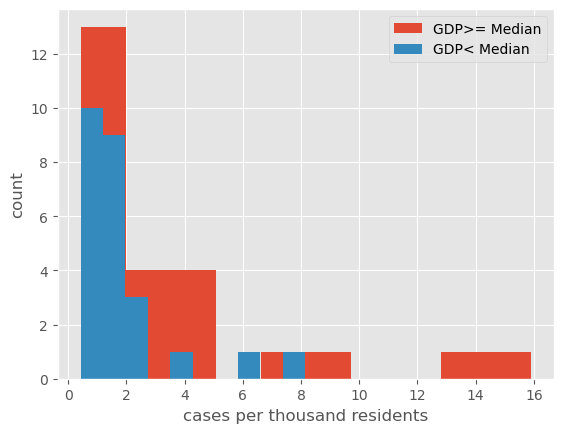

In [8]:
#DEMO
plt.hist(higher_gdp['cases_norm'], label='GDP>= Median')
plt.hist(lower_gdp['cases_norm'], label='GDP< Median')
plt.legend()
plt.xlabel('cases per thousand residents')
plt.ylabel('count')


Let's compare using histograms:

Text(0, 0.5, 'count')

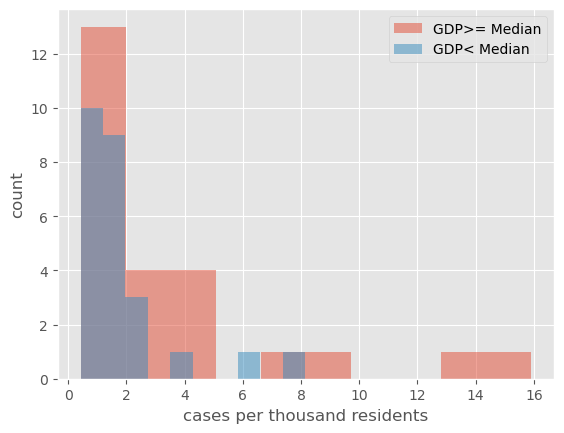

In [9]:
#DEMO
plt.hist(higher_gdp['cases_norm'], alpha=0.5, label='GDP>= Median')
plt.hist(lower_gdp['cases_norm'], alpha=0.5, label='GDP< Median')
plt.legend()
plt.xlabel('cases per thousand residents')
plt.ylabel('count')



**DISCUSSION**

The histogram shows that states with GDPs per capita over the median have higher case counts in general (for instance, the larger bars in the range 2-5), as well as larger maximum values (above 8).  Unfortunately, the data does not provide any insight into why that might be the case. One reason might be that states with higher GDPs may have larger network effects, where more of the population interacts with a larger number of people. For instance, such states may have more of their population employed in office jobs and more likely to travel for their work. 

When an effect is observed visually, we usually want to quantify that effect in some way and then test whether any observed difference is "real"

# Null Hypothesis Testing with Real Data

In [10]:
# Magic cell to make MPL save to both png and pdf
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

When dealing with data from different groups, we will generally observe differences. For instance, we may measure the means or medians of the data sets, and we will usually find that these summary statistics differ between the groups.  At this point, we wish to understand whether the observed difference is "significant": is this difference likely to be a property of the underlying groups, or is it just caused by random variations in the data?


* INTUITION: consider again coin flip, if you flip it twice and observed 'H', 'H', how confident you are in rejecting the null hypothesis (it is a fair coin)?

The **number of samples of random phenomena** has a significant impact on how **accurately we can estimate those phenomena**. When it comes to real data, the problem is amplified because we do not know the ground-truth characterization of the random phenomena producing the data. 



## Small Data Example Using Covid Rates


Let's start by restricting our analysis to a small subset of our data to see how effects observed with small data may be caused simply by random sampling. By restricting our data, we can show examples of the technique that we will be using, and the examples will be small enough to understand easily.

Start by loading the data and calculating the COVID cases per 1000 residents and GDP per 1000 residents:

Now consider the normalized COVID case rates from the first six states and partition them into two sets using alphabetical order. Since Arizona is the third state alphabetically, we can get the first three as follows:

In [11]:
first3=df.loc[:'Arizona']
first3

,cases,population,gdp,urban,cases_norm,gdp_norm
state,,,,,,
Alabama,7068,4903185,230750.1,59.04,1.441512,47.061267
Alaska,353,731545,54674.7,66.02,0.482540,74.738670
Arizona,7648,7278717,379018.8,89.81,1.050735,52.072199


Similarly, we can get the next three using the following:

In [12]:
second3 = df.loc['Arkansas':'Colorado']
second3

,cases,population,gdp,urban,cases_norm,gdp_norm
state,,,,,,
Arkansas,3281,3017804,132596.4,56.16,1.087214,43.938042
California,50470,39512223,3205000.1,94.95,1.277326,81.114143
Colorado,15207,5758736,400863.4,86.15,2.640684,69.609616


Because the data is so small, histograms do not make sense.

Instead, we directly turn to using summary statistics. 

Let's calculate the means for these two groups:

In [13]:
first3['cases_norm'].mean()

0.9915956672540028

In [14]:
second3['cases_norm'].mean()

1.6684081069437913

**Observation**: The mean COVID case rate for states in `first3` is much smaller than for states in `second3`.

**How to test whether this differnece could be caused by random variations in the data.**

**First step:** reduce the observed data to a single statistic, called the *test statistic*:

**test statistic**
>  A single numerical value that can be used in a statistical test.

In [15]:
#DEMO
diff = second3['cases_norm'].mean() - first3['cases_norm'].mean()
diff

0.6768124396897884

**This is a ______ difference!**

Possible hypotheses (explanations):
1. States that come later alphabetically might have higher COVID rates. (Hard to justify?)
2. The states in `second3` might differ from the states in group `first3` in some significant way. (Maybe but... why?)
3. The differences could be caused by random sampling. That is, the COVID rates all come from the same underlying random phenomena, but because of randomness, some states end up with higher rates in the observed data than others. In `first3` and `second3`, it just happened by randomness that `second3` ended up with more states with higher COVID rates, and `first3` ended up with more states with lower rates.

In statistics, we want to create hypotheses that can be *tested*, which means that we can assess the likelihood that the hypothesis is true or false.  In this case, we use the term *statistical hypothesis*:


<div class="alert alert-info">
    <b>Statistical hypothesis</b>
    
**Statistical hypothesis** is an explanation for phenomena observed in a data set that can be formally tested using the data.
</div>

Hypothesis 3 is a very common type of hypothesis when working with two groups of data that have different values for some summary statistic of interest. This type of hypothesis is called the *null hypothesis*:


**Null hypothesis (for multiple groups)**
>   The *null hypothesis* is that there is no real difference between the two data sets, and any differences are just based on random sampling from the underlying population.


Usually denoted by $H_0$

*Intuitively, the zero can be read as implying zero difference between the populations (in the feature being compared).*

**Alternate hypothesis ($H_a$)**
>  the feature being measured actually comes from random distributions that differ by group.

We will conduct a form of *binary hypothesis test*:

**Binary hypothesis test**
>   A binary hypothesis test is a statistical test that decides between two competing statistical hypotheses.

Usually, $H_a$ cannot be tested directly because we do not know ahead of time *how* the underlying phenomena differ. 

Instead, we conduct tests by assuming $H_0$ is true, called a *null hypothesis test*: 

**Null hypothesis significance test (NHST)**
>   A type of binary hypothesis  test that estimates the probability of observing such a large value of the  statistic under the condition that some null hypothesis, $H_0$, is true.

## Two broad approaches to NHSTs:

**Model-based methods**
>   The data is assumed to come from some known statistical distribution; often allows the use of analytical methods.

**Model-free methods**
>   No assumption is made about the data fitting to some statistical model; analytical  methods are usually not possible. 

In model-free methods, techniques must be applied to the data itself to answer questions about the data. 

We want to draw data from the distribution of the data under $H_0$, but we **don't have a model**. Instead, we use 
*resampling* to approximate drawing from the distribution of the data under $H_0$:

**resampling**
>   Resampling is a type of statistical simulation in which new samples are repeatedly drawn from the existing data for each of the groups under consideration

Let's use a coin flip to see the resampling process.

In [31]:
# DEMO
k  = 50 # the number of samples
coins =['H','T']
sample1 = npr.choice(coins,k)
num_heads = np.sum(sample1=='H',)
print(num_heads)
print('The relative frequency of seeing a head is', num_heads/len(sample1))

17
The relative frequency of seeing a head is 0.34


In [32]:
sample2 = npr.choice(sample1,k)
num_heads2 = np.sum(sample2=='H',)
print(num_heads2)
print('The relative frequency of seeing a head is', num_heads2/len(sample1))

20
The relative frequency of seeing a head is 0.4


Our $H_0$:  
* The covid infection rate does not increase with the GDP.
* the data in the two groups (higher GDP states, lower GDP states) come from the **same underlying random experiment**

? What is the random experiments? 

the covid infection rate: (given average covid norm is 5/1000, a randomly selected person is likely to have had covid with 0.005 probability. ---We don't have the information about the model about the random experiment)


We will _______ the data and draw samples:

<div class="alert alert-info">
    <b>Pooling</b>
    
**Pooling** describes the practice of gathering together small sets of data that are assumed to have been *drawn* from the same underlying population and using the combined larger set (the *pool*) to obtain a more precise estimate of that population.
</div>

In [16]:
#let's collect the data from both higher gdp and lower gdp states.
# we can understand the data is the outcome of the same random experiment. (Null hypothesis)
import numpy as np
pooled = np.hstack((lower_gdp['cases_norm'], higher_gdp['cases_norm']))
pooled

array([ 1.441512  ,  1.05073463,  1.08721441,  1.56827509,  2.39521398,
        1.1281067 ,  2.68841522,  1.05379243,  6.03253231,  0.81460365,
        4.14024152,  2.28987191,  1.23227515,  0.4229129 ,  1.64050133,
        1.62674209,  1.00180357,  1.54220599,  0.91433574,  8.13792465,
        1.18379075,  1.53839981,  1.38784498,  0.62829667,  1.19760911,
        0.48254038,  1.27732626,  2.64068365,  7.7693605 ,  4.86154756,
        0.43012363,  4.17603752,  2.26460903,  1.47769859,  3.61001575,
        9.02502328,  0.91069772,  2.23944483,  1.57827656, 13.35841724,
       15.91975886,  1.40014854,  0.59510586,  3.76691466,  2.76942867,
        1.00262517,  1.45728671,  1.85647762,  1.94539831,  0.96585971])

In [17]:
len(lower_gdp['cases_norm'])

25

In [18]:
len(lower_gdp['cases_norm'])

25

In [19]:
# test statistics: the observed difference between two samples.
observed_diff= lower_gdp['cases_norm'].mean() - higher_gdp['cases_norm'].mean()
observed_diff

-1.5854260007930685

For numerical data, we leverage the NumPy.random submodule to draw samples, which we will import as `npr`:

In [20]:
#DEMO
import numpy.random as npr
npr.choice(pooled, 25) # recall the additional variable allows us to select 

array([3.76691466, 1.56827509, 0.62829667, 0.96585971, 0.48254038,
       1.53839981, 2.68841522, 1.00180357, 1.08721441, 1.45728671,
       1.85647762, 1.18379075, 1.19760911, 1.23227515, 3.61001575,
       1.441512  , 3.76691466, 1.53839981, 6.03253231, 2.28987191,
       0.91433574, 0.96585971, 4.17603752, 1.19760911, 1.18379075])

We can randomly draw data from `pooled` using `npr.choice()`, we draw two sets of 25 samples, and see how likely it has a value greater than the observed difference

In [21]:
#DEMO
#Note that the resulting array has a repeated value, even though there are no repeated values in the variable `pooled`. 
sample1 = npr.choice(pooled, 25) 
sample2 = npr.choice(pooled,25)
print(sample1.mean()- sample2.mean())

0.646593561149023


There are two ways to sample from data:
1. **Sampling with replacement:** Items drawn are placed back into the array from which data is being sampled. Any number of items may be drawn.
2. **Sampling without replacement:** Items drawn are removed from the array from which data is being sampled. The maximum number of items that can be drawn is the size of the original array.

`npr.choice()` defaults to sampling with replacement but can perform sampling without replacement if passed the keyword argument `replace=False`.


In [25]:
#DEMO
alist= list(range(1,7))
print(alist)
npr.choice(alist, 4, replace=False)
npr.choice(alist, 4, replace=False)

[1, 2, 3, 4, 5, 6]


array([3, 5, 2, 1])

## bootstrap sampling 
* Sample the data **with replacement**.  
* often used to simulate random values of the test statistic under $H_0$

In [29]:
#DEMO -- run a few times
first_sample = npr.choice(pooled, len(lower_gdp))
second_sample =npr.choice(pooled, len(higher_gdp))
print(f'new group first_sample: {first_sample}')
print(f'new group second_sample: {second_sample}')

new group first_sample: [9.02502328 1.19760911 1.56827509 2.64068365 1.47769859 1.18379075
 0.91069772 1.23227515 0.4229129  0.91069772 1.05379243 3.76691466
 2.64068365 1.08721441 1.00180357 2.28987191 9.02502328 1.40014854
 1.62674209 0.59510586 2.68841522 0.43012363 1.40014854 0.91069772
 1.27732626]
new group second_sample: [ 1.00180357  1.57827656  1.08721441  0.48254038  0.48254038  2.76942867
  1.18379075  1.05379243  3.76691466  1.62674209  7.7693605   0.81460365
  0.59510586  1.57827656  3.61001575 15.91975886  7.7693605   1.00180357
  2.39521398  0.62829667  1.05073463  1.53839981  1.62674209  0.62829667
  0.91433574]


In [30]:
# the original value of test statistis.
print(f'original value of test statistic: {observed_diff}')


original value of test statistic: -1.5854260007930685


In [31]:
print(f'sample value of test statistic: ',
      f'{first_sample.mean() - second_sample.mean()}')

sample value of test statistic:  -0.44438692092203746


## Goal of a NHST: 
* determine whether the observed value of the test statistic could be attributed just to randomness
*  use resampling to estimate probability of  seeing such a large test statistic  under $H_0$

In [43]:
#DEMO -- copy from above and add new lines. Run a few times


first_sample = npr.choice(pooled, len(lower_gdp))
second_sample =npr.choice(pooled, len(higher_gdp))


print(f'original value of test statistic: {observed_diff}')
print(f'sample value of test statistic: ',
      f'{second_sample.mean() - first_sample.mean()}')

original value of test statistic: -1.5854260007930685
sample value of test statistic:  -2.5945182708929657


Note that the sample test statistic can be either positive or negative

Should we consider the signed value or magnitude? It depends on the original hypothesis, and we will discuss this more later.

For now, let's consider only the *magnitude* of the sample test statistic


The probability of seeing such a large value of the test statistic under $H_0$ is called the $\mathbf{p}$**-value**

For now, we will say that the difference is *statistically significant* if the observed $p$-value is smaller than a threshold

**IMPORTANT** Need to declare ahead of time:
* Exactly what is being tested
* Criterion for statistical significance

The significance threshold (for rejecting $H_0$) determines the max. prob. of rejecting the null hypothesis when it is actually true

## Resampling Simulation for Estimating $p$-value


In [48]:
#DEMO
# These are common to most simulations:
# 1) Set up the number of iterations (no. of samples from the pool)
# 2) Initialize our counter to zero
num_sims = 10_000
count = 0

first_len = len(lower_gdp)
second_len = len(higher_gdp)

# Put these outside the loop to save execution time 
# since they don't change.
# Even though we know these, it is good to get in the habit of 
# setting them dynamically from the data


diff = abs(lower_gdp['cases_norm'].mean() - higher_gdp['cases_norm'].mean())
print('The magnitude of observed difference is', diff)
for sim in range(num_sims):
    # Bootstrap sampling
    first_sample = npr.choice(pooled, first_len)
    second_sample = npr.choice(pooled, second_len)
    
    # Calculate the test statistis
    newdiff = abs(first_sample.mean() - second_sample.mean())
    # Update the counter if observed difference as large as original
    if (newdiff>= diff):
        count += 1

print(f'Prob. of seeing a result this extreme =~ {count / num_sims}')

The magnitude of observed difference is 1.5854260007930685
Prob. of seeing a result this extreme =~ 0.0674


**Draw conclusions**

Since this $p$-value is   larger than our threshold of 5% (i.e., 0.05), we **fail to reject the null hypothesis**.  

**NOTE** This does not mean that there is no difference among these two groups. There could be a difference, but **the data is not sufficient to be sure that they come from different distributions.**

### Additional Exercise: Does covid infection rate increases with states with higher urban index?


### Partitioning Based on Urban Index


In [46]:
m_urban = df['urban'].median()
higher_urban = df.query('urban>@m_urban')
lower_urban = df.query('urban <= @m_urban')
len(higher_urban), len(lower_urban)

(25, 25)

Now we use that median to partition the data and plot the histograms:

Text(0, 0.5, 'count')

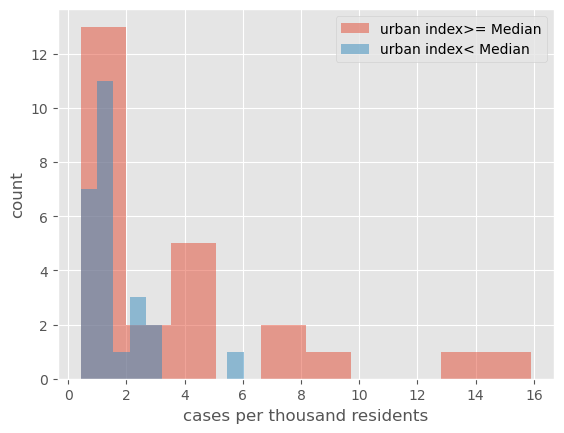

In [47]:
plt.hist(higher_urban['cases_norm'], alpha=0.5, label='urban index>= Median')
plt.hist(lower_urban['cases_norm'], alpha=0.5, label='urban index< Median')
plt.legend()
plt.xlabel('cases per thousand residents')
plt.ylabel('count')


As with normalized GDP, a substantial difference in the distribution of the COVID case rates is seen for states that are more urban versus less urban. The average normalized case rates for these partitions are:

In [48]:
higher_urban['cases_norm'].mean()

3.890874990432076

In [49]:
lower_urban['cases_norm'].mean()

1.5461729098384682

In [63]:
#DEMO
diff_urban = higher_urban['cases_norm'].mean() - lower_urban['cases_norm'].mean()
print(diff_urban)

pooled_cases = df['cases_norm']
pooled_cases


2.344702080593608


state
Alabama            1.441512
Alaska             0.482540
Arizona            1.050735
Arkansas           1.087214
California         1.277326
Colorado           2.640684
Connecticut        7.769361
Delaware           4.861548
Florida            1.568275
Georgia            2.395214
Hawaii             0.430124
Idaho              1.128107
Illinois           4.176038
Indiana            2.688415
Iowa               2.264609
Kansas             1.477699
Kentucky           1.053792
Louisiana          6.032532
Maine              0.814604
Maryland           3.610016
Massachusetts      9.025023
Michigan           4.140242
Minnesota          0.910698
Mississippi        2.289872
Missouri           1.232275
Montana            0.422913
Nebraska           2.239445
Nevada             1.640501
New Hampshire      1.578277
New Jersey        13.358417
New Mexico         1.626742
New York          15.919759
North Carolina     1.001804
North Dakota       1.400149
Ohio               1.542206
Oklahoma      

We will use the difference in sample means as the test statistic for a NHST, so one of our first steps is to calculate the value of this test statistic:

For this case, the pooled data is simply all of the normalized COVID data:

Copy the simulation from the previous section and modify it to draw data to represent new `higher_urban` and `lower_urban` groups:

In [64]:
num_sims =10000
count =0 

higher_len= len(higher_urban)
lower_len = len(lower_urban)
for sim in range(num_sims):
    resample1 = npr.choice(pooled_cases, higher_len)
    resample2 = npr.choice(pooled_cases, lower_len)
    newdiff = np.abs(resample1.mean() - resample2.mean())
    
    # see if we observe difference as big as the original
    if newdiff >= diff_urban:
        count += 1
print("the prob. of seeing a difference this big is", count/num_sims)

the prob. of seeing a difference this big is 0.0096


<!-- **<font color=orange>Scenario B:</font>** Suppose that we always decide $A_1$. For $P(A_0) = \frac{1}{10}$, $P(A_1)=\frac{9}{10}$, we have:

\begin{align*}
P(A_0|B_0) &\underset{A_1}{\overset{A_0}{\gtrless}} P(A_1|B_0)\\
\frac{P(B_0|A_0)P(A_0)}{P(B_0)} &\underset{A_1}{\overset{A_0}{\gtrless}} \frac{P(B_0|A_1)P(A_1)}{P(B_0)} \\
\frac{\frac{7}{8}\times\frac{1}{10}}{\frac{19}{80}} &\underset{A_1}{\overset{A_0}{\gtrless}} \frac{\frac{1}{6}\times\frac{9}{10}}{\frac{19}{80}}\\
\frac{7}{19} &\underset{A_1}{\overset{A_0}{\gtrless}} \frac{12}{19} \Rightarrow \text{ Decide }A_1
\end{align*}

So, when $B_0$ is received, MAP decision rule is to decide $A_1$ with probability $P(A_1|B_0)=\frac{12}{19}$.

Similarly, when $B_1$ is received, MAP decision rule is to decide $A_1$ with probability $P(A_1|B_1)=\frac{60}{61}$.

When using the MAP decision rule, we will always decide $A_1$. This does not mean we will not make an error. We will make the correct decision for when receiving $B_0$ with $\frac{12}{19}$ probability. But we will be in error with $1-\frac{12}{19}$ probability for when we receive $B_0$. We apply the same reasoning for $B_1$.

$$P(E) = P(E|B_0)P(B_0) + P(E|B_1)P(B_1)$$

where

$$P(B_0) = P(B_0|A_0)P(A_0) + P(B_0|A_1)P(A_1) = \frac{7}{8}\times\frac{1}{10} + \frac{1}{6}\times\frac{9}{10} = \frac{19}{80}$$
and
$$P(B_1) = P(B_1|A_0)P(A_0) + P(B_1|A_1)P(A_1) = \frac{1}{8}\times\frac{1}{10} + \frac{5}{6}\times\frac{9}{10} = 1- P(B_0) = \frac{61}{80}$$

For this decision rule, we have that: 

$$P(E) = P(E|B_0)P(B_0) + P(E|B_1)P(B_1) = \left(1-\frac{12}{19}\right)\times\frac{19}{80} + \left(1-\frac{60}{61}\right)\times\frac{61}{80} = 0.1$$ -->

<!-- We changed the prior probability for both transmitters. In scenario B we are assuming that the probability that the Tx $A_0$ was used at 10\% chance. Whereas in scenario A, we are assuming that the probability that Tx $A_0$ was used at 40\%.  -->

___